**We teseted our Bollinger Band strategy here on 50 stocks for 5 years(In sample)
to check whether it is better than the ensemble strategy or not.**

### Zipline installation

In [ ]:
%%capture
%%bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure
make
make install

In [ ]:
%%capture
%pip install zipline-reloaded

In [ ]:
import zipline
zipline.__version__

'3.0.3'

### Quantstats Installation

In [ ]:
%%capture
!pip install quantstats

# Bactest with Zipline

In [ ]:
import numpy as np
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, order,record, order_target, get_open_orders,order_target_percent, order_percent,order_target_value
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions  # Zipline extensions are needed for listing sids
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
import talib
import yfinance as yf

from datetime import datetime
from os.path import abspath
from pandas_datareader import data as pdr

# from hurst import compute_Hc
from sklearn.preprocessing import MinMaxScaler
from zipline.api import symbol, get_open_orders

yf.pdr_override()

# Zipline imports
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order,
                         order_target,
                         order_value,
                         record,
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from keras.models import load_model

# ROOT_DIR = abspath('../')
# sys.path.append(ROOT_DIR)

In [ ]:
from zipline.data import bundles

bundle_name = 'sp50'

bundles.register(
    bundle_name,
    bundles.csvdir.csvdir_equities(
        ['daily'],
        '/content/drive/MyDrive/Colab Notebooks/Data/sp50'
    ),
    calendar_name='NYSE',
)

bundles.bundles

In [ ]:
bundles.ingest(bundle_name)

In [ ]:
bundle = 'sp50'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
sp50tickers = [coin.symbol for coin in assets]

In [ ]:
def calculate_bollinger_bands(prices, dev, window=20):
    """
    Calculate Bollinger Bands for a given series of prices.

    Parameters:
    - prices (pd.Series or np.array): Series of prices.
    - dev (float): Number of standard deviations to use for the bands.
    - window (int, optional): Rolling window size for calculating moving averages. Default is 20.

    Returns:
    - upper_band (float): Upper Bollinger Band.
    - sma (float): Simple Moving Average.
    - lower_band (float): Lower Bollinger Band.
    """

    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (dev * rolling_std)
    lower_band = sma - (dev * rolling_std)
    return upper_band, sma, lower_band

def plots(results):
    """
    Generate plots comparing strategy returns with a benchmark.

    Parameters:
    - results (pd.DataFrame): DataFrame containing strategy returns.

    Returns:
    - None
    """

    start = results.index[0]
    end = results.index[-1]
    benchmark = yf.download("^GSPC", start=start, end=end)["Adj Close"].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index
    qs.reports.full(
        results["returns"],
        benchmark=benchmark,
        match_dates=True,
        figsize=(8, 4),
        df=results
        # output='/content/asset50rsi_bg_without_lstm.html'
    )


def group1_ensemble_model_signals(context, data):
    """
    Generates trading signals based on the provided context and data.

    Parameters:
    - context: Context object containing necessary parameters.
    - data: Data object containing price data.

    Returns:
    - today_signal (dict): Signal for the last day for each ticker. It can take values [-1, 0, 1].
    """

    today_signal = {}

    for ticker in context.tickers:

        prices = data.history(symbol(ticker), "price", context.window + 1, "1d")
        upper_band, mid_band, lower_band = calculate_bollinger_bands(
            prices, context.bollinger_dev, window=context.window
        )
        # rsi_value = calculate_rsi(prices, window=context.window)
        current_price = data.current(symbol(ticker), "price")
        open_orders = get_open_orders(ticker)

        signal = 0  # Default signal is hold

        if ticker not in open_orders:
            if (
                current_price < lower_band
                #and rsi_value < 30
                # and predicted_price_tomorrow > current_price
                and ticker not in context.buy_stocks
            ):
                signal = 1  # Buy Signal
            elif (
                current_price > upper_band
                # and rsi_value > 70
                # and predicted_price_tomorrow < current_price
                and ticker in context.buy_stocks
            ):
                signal = -1  # Sell Signal

        today_signal[ticker] = signal

    return today_signal


In [ ]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2022-12-31') # Backtesting for 1 year

BASE_CAPITAL = 100_000

[*********************100%%**********************]  1 of 1 completed


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-03-19   2018-03-19
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          39.52%       50.92%
Mean Active Return         0.0%         0.01%
CAGR﹪                     4.92%        6.12%

Sharpe                     0.43         0.46
Prob. Sharpe Ratio         82.28%       84.4%
Smart Sharpe               0.38         0.42
Sortino                    0.59         0.66
Smart Sortino              0.53         0.59
Sortino/√2                 0.42         0.47
Smart Sortino/√2           0.37         0.42
Omega                      1.1          1.1

Max Drawdown               -33.92%      -43.2%
Longest DD Days            361          410
Volatility (ann.)          22.01%       25.56%
R^2                        0.76         0.76

0.012617758300213174



[Worst 5 Drawdowns]

    Start       Valley      End           Days    Max Drawdown    99% Max Drawdown
--  ----------  ----------  ----------  ------  --------------  ------------------
 1  2020-01-17  2020-03-23  2020-11-06     295         -43.204             -36.849
 2  2021-11-16  2022-10-12  2022-12-30     410         -30.600             -28.537
 3  2018-10-01  2018-12-24  2019-03-20     171         -20.296             -17.202
 4  2019-04-30  2019-05-31  2019-06-19      51          -5.969              -5.868
 5  2019-07-11  2019-08-14  2019-09-16      68          -5.317              -4.998



[Strategy Visualization]
via Matplotlib


Average Long Exposure = 114640.06350833997
Average Short Exposure = 0.0
Average Net Leverage = 0.8214982142402932
Average Gross Leverage = 0.8214982142402932
Max Leverage = 1.7153299576472185



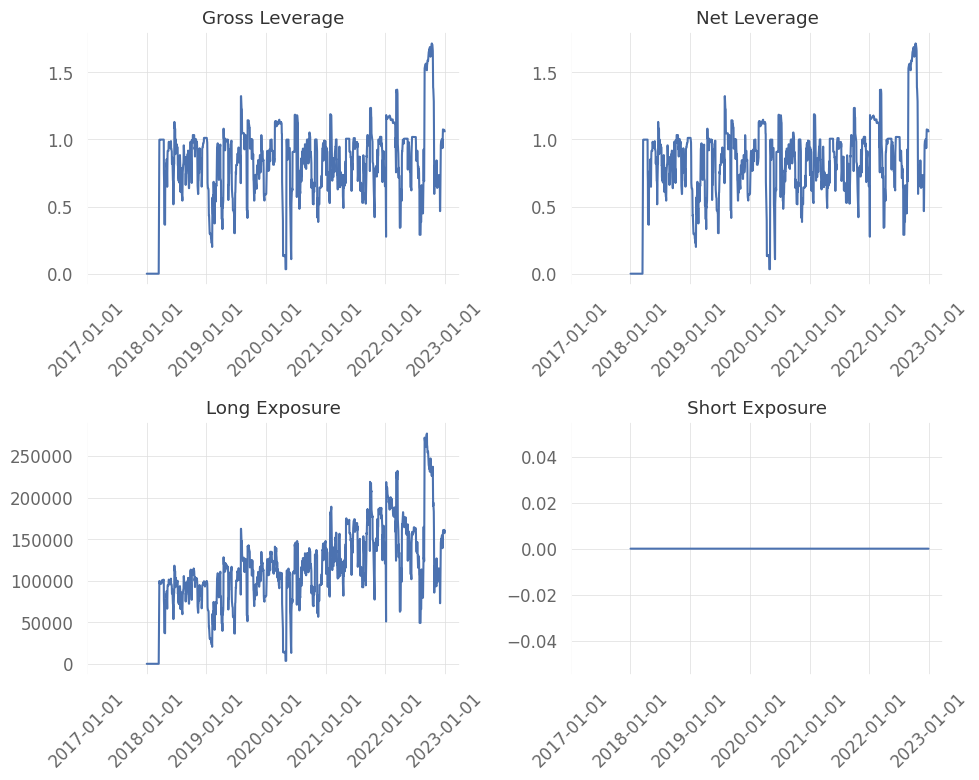

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BRK-B BX BXP CAT CCI CDNS CE CEG COF CPB CPT DIS EA FMC FOX GOOGL IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


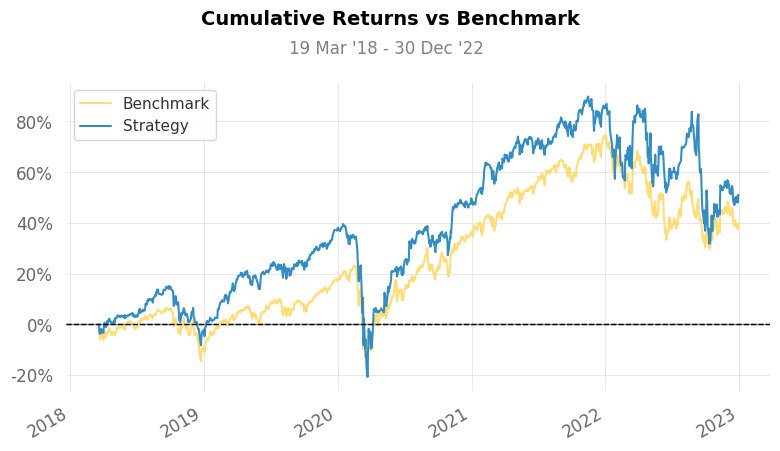

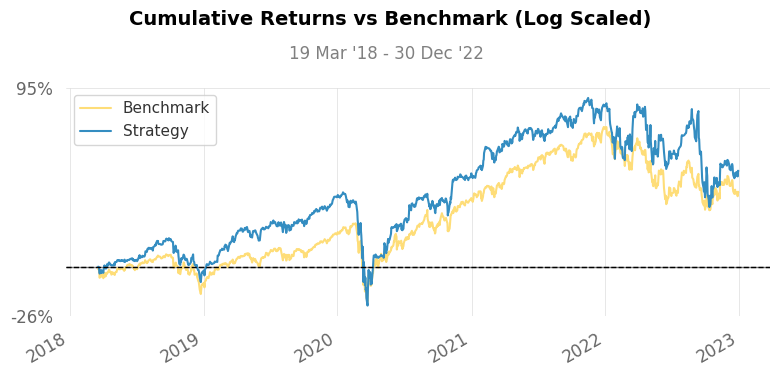

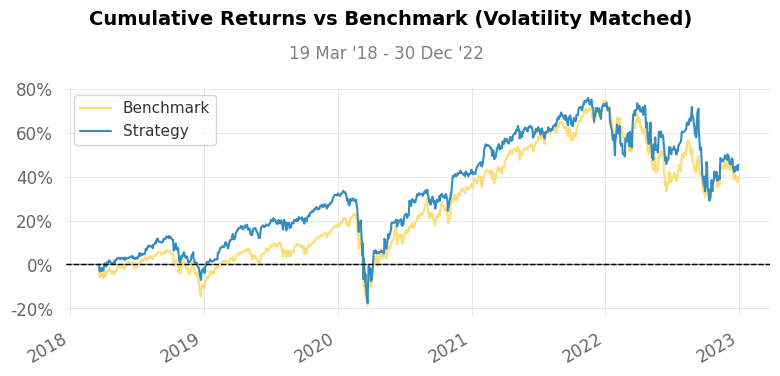

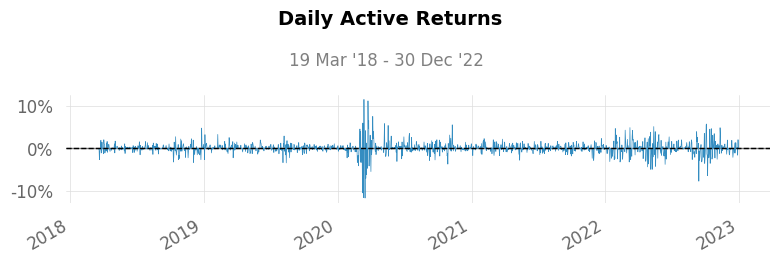

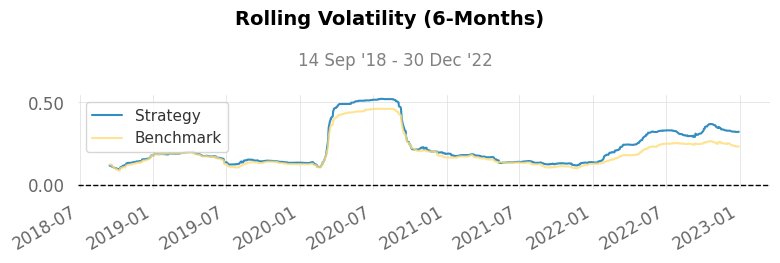

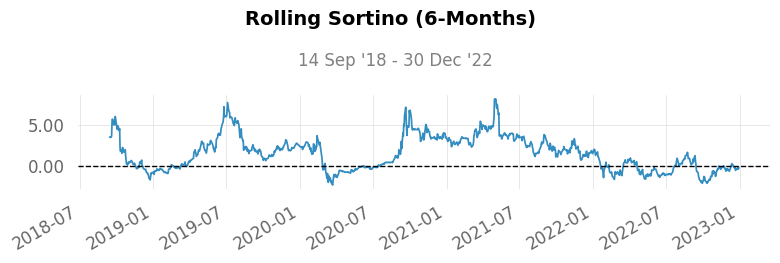

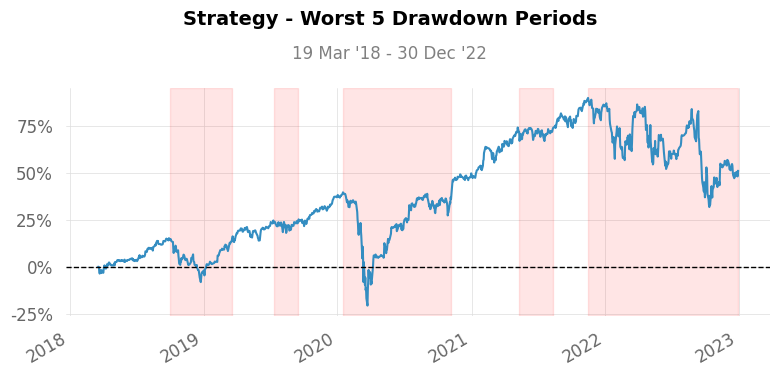

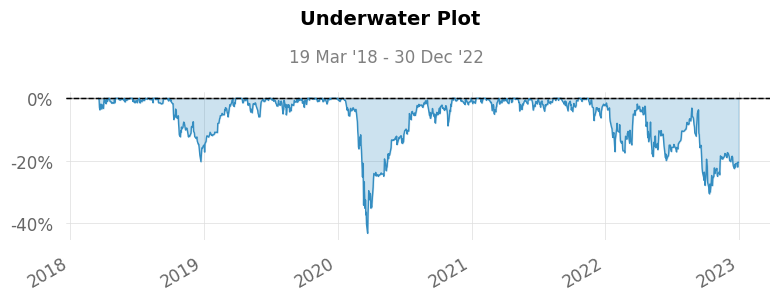

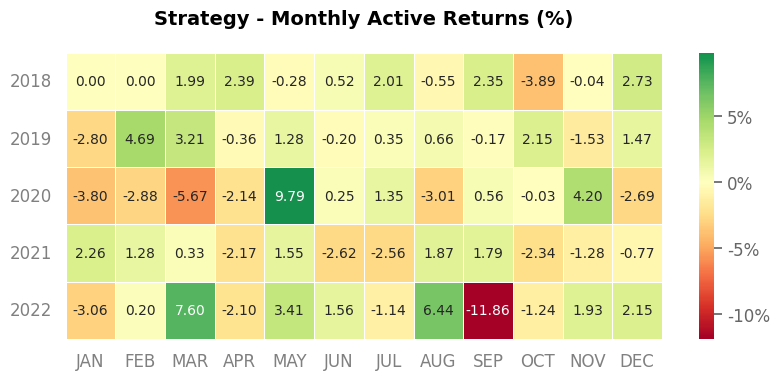

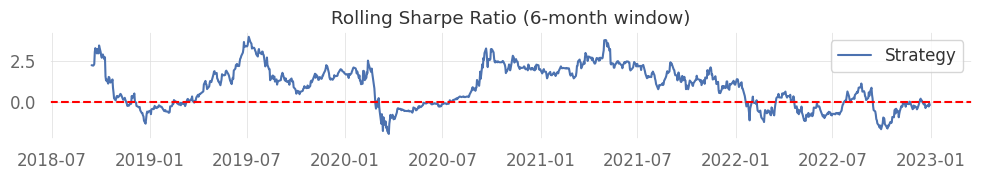

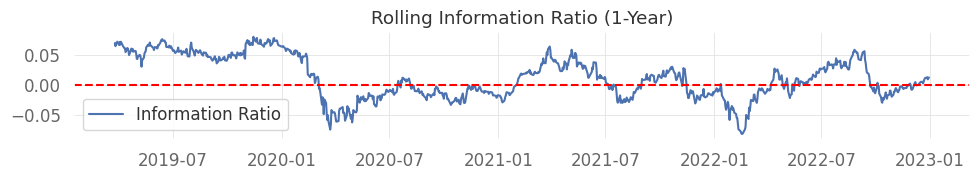

[*********************100%%**********************]  1 of 1 completed


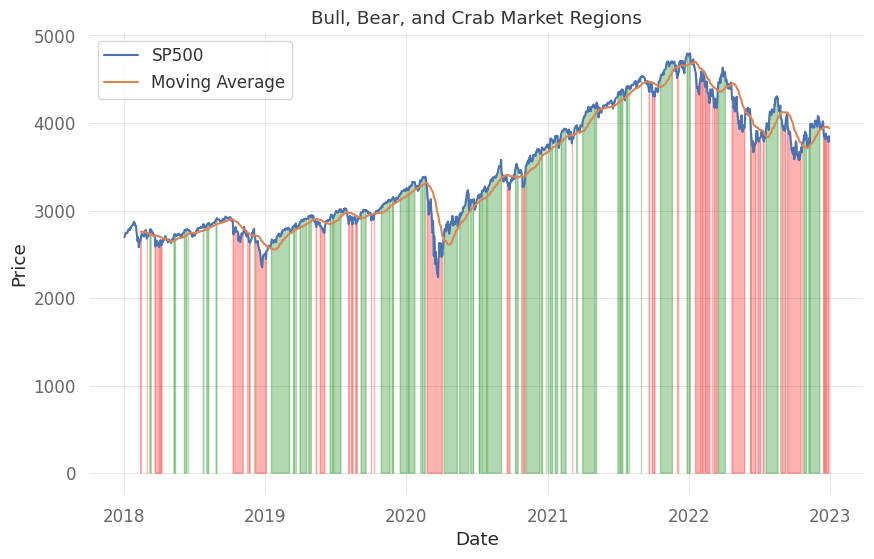

Total Trades: 1480
Daily Trades: 2
Weekly Trades: 10
Monthly Trades: 42





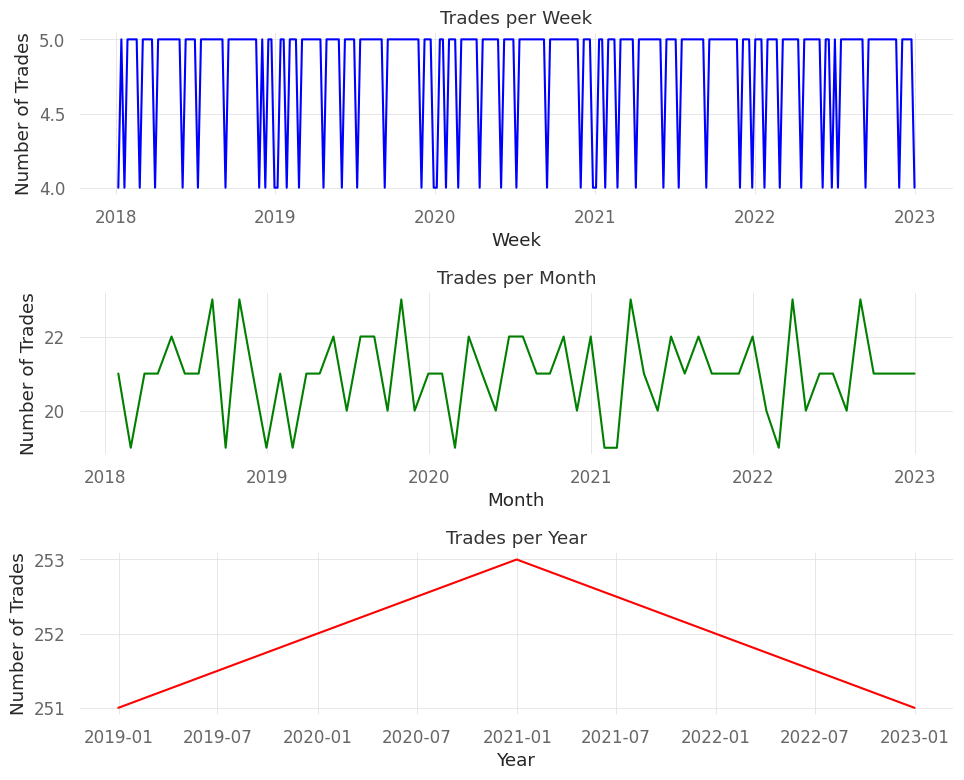

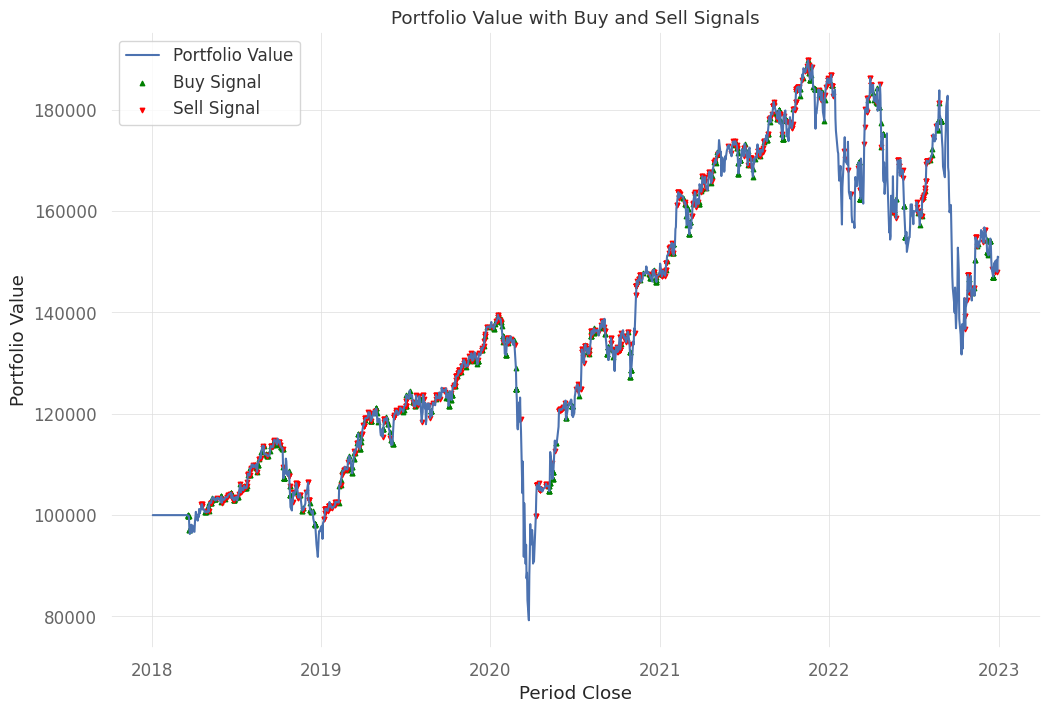

Inference time for 50 assets: 178.608705 seconds


In [ ]:
import time
start_time = time.time()

def initialize(context):
    context.idx = 0
    context.tickers = sp50tickers
    context.window = 20
    context.bollinger_dev = 1.5
    context.stop_loss = 0.05
    context.take_profit = 0.05
    context.stops, context.profits = 0, 0
    context.buy_stocks = set()
    context.cash_pct = 0.25
    context.atr_window = 14
    context.atr_dev = 1.5
    context.buy_count, context.sell_count = 0, 0
    context.current_date = None
    context.lstm_model = load_model("/content/lstm_12_p50_ckp_13_24_e150.h5")
    context.model_window = 52

# Define the handle_data function
def handle_data(context, data):
    context.idx += 1
    if context.idx < context.model_window:
        return

    # Generate signals using groupx_ensemble_model_signals function
    signal = group1_ensemble_model_signals(context, data)


    # Execute trades based on the generated signals
    for ticker, signal_value in signal.items():
        open_orders = get_open_orders(ticker)

        if ticker not in open_orders:
            if signal_value == 1 and ticker not in context.buy_stocks:
                if context.portfolio.cash > 0:
                    # print(signal)
                    order_value(symbol(ticker), context.portfolio.cash * context.cash_pct)  # Buy Signal
                    context.buy_stocks.add(ticker)

            elif signal_value == -1 and ticker in context.buy_stocks:
                order_target_percent(symbol(ticker), 0)  # Sell Signal
                context.buy_stocks.remove(ticker)


# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp50',
)
plots(results)

end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time for 50 assets: {inference_time:.6f} seconds")
